In [33]:
import utils
import pandas as pd
import numpy as np
import os
import json
import matplotlib.pyplot as plt
import seaborn as sns

In [34]:
from evalplus.data import get_human_eval_plus, get_human_eval_plus_hash
from evalplus.evaluate import get_groundtruth
problems = get_human_eval_plus(mini=False)
dataset_hash = get_human_eval_plus_hash()
expected_output = get_groundtruth(problems, dataset_hash, []) 

Load from ground-truth from /home/kaiboliu/.cache/evalplus/84f4b93a1270b492e4c54d5212da7a5b.pkl


1.  Prepare the results of TC

In [35]:
def get_pre_trigger_df(df_raw):
    df=df_raw.copy()
    false_rows = df[df['out_correct'] == False]
    task_input_pairs = false_rows[['task_id', 'input_name']].drop_duplicates()
    filtered_df = df.merge(task_input_pairs, on=['task_id', 'input_name'], how='inner')
    unique_combinations = filtered_df.drop_duplicates(subset=['task_id', 'input_name'])
    new_rows = unique_combinations.copy()
    new_rows['sol_name'] = 'put'
    new_rows['out'] = new_rows['ref_out']
    new_rows['out_correct']=True
    new_rows['extra_submit_res']=True
    new_rows['submit_res']=True
    new_df=pd.concat([filtered_df, new_rows], ignore_index=True)
    return new_df.copy()
can_dfa_tc=pd.read_pickle("../Data/ep_can_dfa_tc.pkl")
can_tc_pre_trigger=get_pre_trigger_df(can_dfa_tc)
can_tc_trigger=utils.ep_get_trigger_df(can_tc_pre_trigger,'tc')
can_tc_all_res={}
for i in range(2,11):
    can_tc_all_res[i]=utils.ep_compute_res(can_tc_trigger,i,'tc')
for i in range(2,11):
    print(f"k={i}:   ",end="")
    print(can_tc_all_res[i]['FP_rate'].sum())

k=2:   2.574603174603175
k=3:   3.0285714285714285
k=4:   3.411111111111111
k=5:   3.7698412698412698
k=6:   4.123809523809523
k=7:   4.477777777777778
k=8:   4.688888888888889
k=9:   4.9
k=10:   5.0


2.  Prepare the results of DPP

In [36]:
ep_dfa_dfp=pd.read_pickle("../Data/ep_dfa_dfp.pkl")
can_dfp_pre_trigger=get_pre_trigger_df(ep_dfa_dfp[ep_dfa_dfp['sol_name']!='put'])
can_dfp_trigger=utils.ep_get_trigger_df(can_dfp_pre_trigger,'dfp')
can_dfp_all_res={}
for i in range(2,11):
    print(f"compute i ={i}")
    can_dfp_all_res[i]=utils.ep_can_compute_res(can_dfp_trigger,i,'dfp')

get_triger: 1000/1391
compute i =2
compute i =3
compute i =4
compute i =5
compute i =6
compute i =7
compute i =8
compute i =9
compute i =10


In [37]:
for i in range(2,11):
    print(f"k={i}:   ",end="")
    recall=can_dfp_all_res[i]['TP_rate'].sum()/150
    precision=can_dfp_all_res[i]['precision'].mean()
    print(can_dfp_all_res[i]['FP_rate'].sum(),
          can_dfp_all_res[i]['FP_bad_input_rate'].sum(),
          can_dfp_all_res[i]['FP_rate'].sum()-can_dfp_all_res[i]['FP_bad_input_rate'].sum(),
          )

k=2:   41.138888888888886 27.13275428535511 14.006134603533777
k=3:   36.094047619047615 26.791783622129444 9.302263996918171
k=4:   33.3063492063492 26.5845020812419 6.721847125107303
k=5:   31.746031746031747 26.623853723911594 5.122178022120153
k=6:   30.673809523809528 26.625898058014897 4.0479114657946305
k=7:   29.84166666666667 26.58630439735703 3.2553622693096393
k=8:   29.133333333333333 26.516296296296296 2.6170370370370364
k=9:   28.5 26.433333333333334 2.0666666666666664
k=10:   28.0 26.333333333333332 1.6666666666666679


3. Prepare the results of CHAT

In [38]:

ep_chat_res=pd.read_pickle("../Data/ep_chat_res.pkl")
ep_ref_chat=pd.read_pickle("../Data/ep_ref_chat.pkl")
ep_df_chat=ep_chat_res.merge(ep_ref_chat,on=['task_id','input_name'],how='left')


#Extract the outputs of LLM-generated test cases
chat_outs = pd.DataFrame(columns=['task_id', 'input_name', 'chat_out'])
with open("../Datasets/EvalPlus/GenInputs/gen_testcases_outputs.json","r") as f:
    chat_out_json=json.load(f)
for task_key in chat_out_json:
    this_task_json=chat_out_json[task_key]
    task_id=task_key.replace('/','_')
    inp_len=len(this_task_json)
    new_rows=[]
    for i in range(inp_len):
        #print(f"{task_id} input_{i}")
        output=this_task_json[i]
        new_row=[task_id,f"input_{i}",output]
        new_rows.append(new_row)
    df_new_rows=pd.DataFrame(new_rows, columns=['task_id', 'input_name', 'chat_out'])
    chat_outs=pd.concat([chat_outs,df_new_rows],ignore_index=True)

# If PUT‘s output is different with LLM-generated test out, the test case is a TP or FP
ep_df_chat=ep_df_chat.merge(chat_outs,on=['task_id','input_name'],how='left')
ep_df_chat['triger']= (ep_df_chat['out']!=ep_df_chat['chat_out'])
ep_df_chat['out_correct']= (ep_df_chat['chat_out']==ep_df_chat['ref_out'])
ep_df_chat['final_valid']=ep_df_chat['input_valid'] & ep_df_chat['out_correct'] 
def check_triger_valid(row):
    if isinstance(row['chat_out'],list) and len(row['chat_out']) == 1 and row['out'] == row['chat_out'][0]:
        return False
    return True
ep_df_chat['triger_valid']=ep_df_chat.apply(check_triger_valid, axis=1)
ep_df_chat['triger']=ep_df_chat['triger']&ep_df_chat['triger_valid']

In [39]:
can_res_chat=pd.DataFrame(columns=['task_id','total','FP_bad_oracle','FP_bad_input'])
for task_id in ep_df_chat['task_id'].unique():
    df_pid=ep_df_chat[ep_df_chat['task_id']==task_id]
    df_pid=df_pid.drop_duplicates(subset=['input_name'])
    total=len(df_pid)
    df_pid=df_pid[df_pid['triger']==True]
    FP_bad_oracle=len( df_pid[  (df_pid['final_valid']==False) &df_pid['input_valid']==True ]    )
    FP_bad_input=len( df_pid[  df_pid['input_valid']==False ]  )
    can_res_chat.loc[len(can_res_chat)]=[task_id,total,FP_bad_oracle,FP_bad_input]
can_res_chat['FP_bad_oracle_rate']=can_res_chat['FP_bad_oracle']/can_res_chat['total']
can_res_chat['FP_bad_input_rate']=can_res_chat['FP_bad_input']/can_res_chat['total']
print(
    can_res_chat['FP_bad_oracle_rate'].sum(),
    can_res_chat['FP_bad_input_rate'].sum()
)

29.466725448756662 1.8263890111723105


4. Plot the figure.

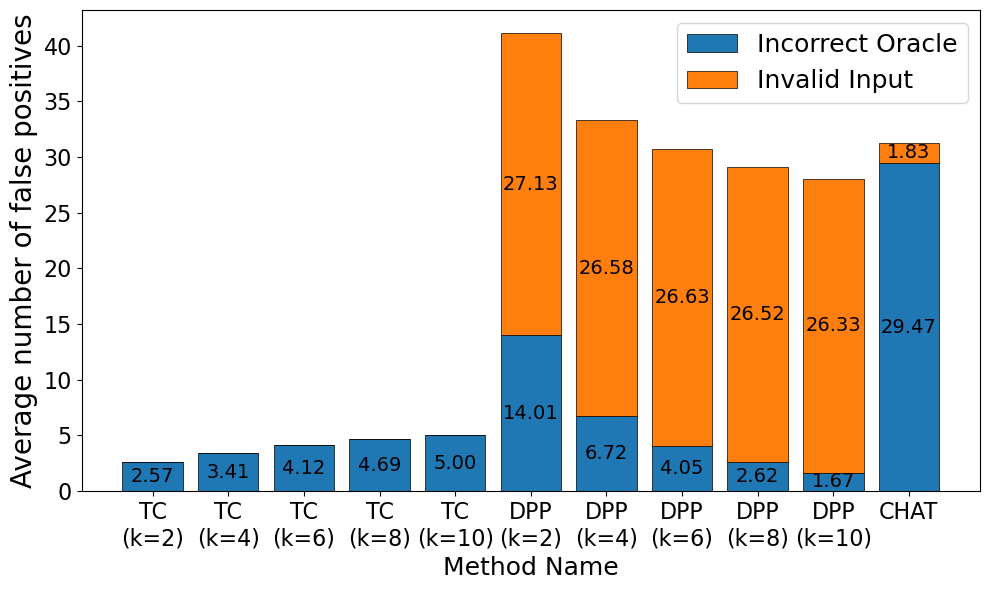

In [40]:
import matplotlib.pyplot as plt
import numpy as np

# 示例数据
x_labels = ['TC\n(k=2)','TC\n(k=4)','TC\n(k=6)','TC\n(k=8)','TC\n(k=10)',
                 'DPP\n(k=2)','DPP\n(k=4)','DPP\n(k=6)','DPP\n(k=8)','DPP\n(k=10)',
                 'CHAT\n',] 
data1=[]
data2=[]
for i in range(2,11,2):
    data1.append(can_tc_all_res[i]['FP_rate'].sum())
    data2.append(0)
for i in range(2,11,2):
    data1.append(can_dfp_all_res[i]['FP_rate'].sum()-can_dfp_all_res[i]['FP_bad_input_rate'].sum())
    data2.append(can_dfp_all_res[i]['FP_bad_input_rate'].sum())
data1.append(can_res_chat['FP_bad_oracle_rate'].sum())
data2.append(can_res_chat['FP_bad_input_rate'].sum())


x = np.arange(len(x_labels))
fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x, data1, label='Incorrect Oracle',edgecolor='black', linewidth=0.5)
bars2 = ax.bar(x, data2, bottom=data1, label='Invalid Input',edgecolor='black', linewidth=0.5)

for i in range(len(x)):
    total = data1[i] + data2[i]

    ax.text(x[i], data1[i] / 2, f'{data1[i]:.2f}', ha='center', va='center', color='black', fontsize=14)

    if i<5:
        continue
    ax.text(x[i], data1[i] + data2[i] / 2, f'{data2[i]:.2f}', ha='center', va='center', color='black', fontsize=14)
    
   

ax.set_xlabel('Method Name',fontsize=18)
ax.set_ylabel('Average number of false positives',fontsize=20)
ax.tick_params(axis='y', labelsize=16)
ax.set_xticks(x)
ax.set_xticklabels(x_labels, fontsize=16, rotation=0, ha='center')
ax.legend(fontsize=18)
plt.tight_layout()
plt.show()